# Electricity Demand Forecasting in Delhi Using Machine Learning

This notebook implements the complete workflow used in the research paper:

> **Electricity Demand Forecasting in Delhi Using Machine Learning and Predictive Analytics**

It covers:

1. Data loading and preprocessing  
2. Feature engineering (lag features, moving average, time features)  
3. Train–test split (time-based)  
4. Baseline model (persistence)  
5. Linear Regression model  
6. Random Forest Regressor  
7. XGBoost Regressor (optional)  
8. Model evaluation using **MAE** and **RMSE**  
9. Visualization of predictions and feature importance  
10. Last 30 days demand trend




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    xgb_available = False
    print("XGBoost not installed. Install with: pip install xgboost if needed.")


In [2]:

csv_path = "powerdemand_5min_2021_to_2024_with weather.csv"

df = pd.read_csv(csv_path)
print("Columns:", df.columns.tolist())
print("Shape:", df.shape)
df.head()


Columns: ['Unnamed: 0', 'datetime', 'Power demand', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres', 'year', 'month', 'day', 'hour', 'minute', 'moving_avg_3']
Shape: (393440, 15)


,Unnamed: 0,datetime,Power demand,temp,dwpt,rhum,wdir,wspd,pres,year,month,day,hour,minute,moving_avg_3
0,0,2021-01-01 00:30:00,2014.00,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,30,NaN
1,1,2021-01-01 00:35:00,2005.63,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,35,NaN
2,2,2021-01-01 00:40:00,1977.60,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,40,1999.076667
3,3,2021-01-01 00:45:00,1976.44,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,45,1986.556667
4,4,2021-01-01 00:50:00,1954.37,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,50,1969.470000


## 2. Preprocessing

- Parse `datetime`
- Set it as index
- Sort values
- Resample from 5-minute to hourly resolution using mean


In [3]:
# drop index column
df = df.drop(columns=['Unnamed: 0'])

# convert to datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# set datetime index for resampling
df = df.set_index('datetime')

# resample to hourly mean to reduce dataset size
df_hourly = df.resample('H').mean()

print(df_hourly.shape)
print(df_hourly.head())

(34585, 13)
                     Power demand  temp  dwpt   rhum  wdir  wspd     pres  \
datetime                                                                    
2021-01-01 00:00:00   1975.541667   8.0  6.90   93.0   0.0   0.0  1017.00   
2021-01-01 01:00:00   1805.590000   8.0  6.90   93.0   0.0   0.0  1017.00   
2021-01-01 02:00:00   1665.914167   7.5  6.25   92.0   0.0   0.0  1018.05   
2021-01-01 03:00:00   1607.331667   7.0  6.30   95.5   0.0   0.0  1018.05   
2021-01-01 04:00:00   1676.528333   6.5  6.50  100.0   0.0   0.0  1017.00   

                       year  month  day  hour  minute  moving_avg_3  
datetime                                                             
2021-01-01 00:00:00  2021.0    1.0  1.0   0.0    42.5   1976.777500  
2021-01-01 01:00:00  2021.0    1.0  1.0   1.0    27.5   1822.649167  
2021-01-01 02:00:00  2021.0    1.0  1.0   2.0    27.5   1675.064722  
2021-01-01 03:00:00  2021.0    1.0  1.0   3.0    27.5   1608.205278  
2021-01-01 04:00:00  2021.0 

C:\Users\paulp\AppData\Local\Temp\ipykernel_26680\2262038785.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean()


## 3. Feature Engineering

We add:

- 3-hour moving average of power demand  
- Lag features for last 24 hours (`lag_1` … `lag_24`)  
- Weather features are kept as predictors


In [4]:
for i in range(1, 25):  # last 24 hours
    df_hourly[f'lag_{i}'] = df_hourly['Power demand'].shift(i)

df_hourly = df_hourly.dropna()

# lag features for last 24 hours
for i in range(1, 25):
    df_hourly[f'lag_{i}'] = df_hourly['Power demand'].shift(i)

# drop rows with missing lag values
df_hourly = df_hourly.dropna()

# Feature columns
feature_cols = ['temp','dwpt','rhum','wdir','wspd','pres','moving_avg_3'] + \
               [f'lag_{i}' for i in range(1, 25)]

X = df_hourly[feature_cols]
y = df_hourly['Power demand']

print(X.shape, y.shape)


(25087, 31) (25087,)


## 4. Baseline Model – Persistence

We use previous hour's demand as prediction.


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


# 80-20 split without shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# baseline model
baseline_pred = X_test['lag_1']
baseline_mae = mean_absolute_error(y_test, baseline_pred)



print("Baseline MAE:", baseline_mae)


Baseline MAE: 239.66338029507915


## 5. Linear Regression Model


In [6]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))

print("Linear Regression MAE:", mae_lr)
print("Linear Regression RMSE:", rmse_lr)

Linear Regression MAE: 7.23205846063261
Linear Regression RMSE: 20.204557045124076


## 6. Random Forest Regressor


In [7]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

In [8]:
mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))

print("Random Forest MAE:", mae_rf)
print("Random Forest RMSE:", rmse_rf)

Random Forest MAE: 15.651383174316829
Random Forest RMSE: 56.61899132682138


## 7. XGBoost Regressor 


In [9]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))

print("XGBoost MAE:", mae_xgb)
print("XGBoost RMSE:", rmse_xgb)


XGBoost MAE: 37.28782904885133
XGBoost RMSE: 101.3028225542478


## 8. Model Performance Comparison


In [10]:
results = {
    "Baseline": [baseline_mae, "-"],
    "Linear Regression": [mae_lr, rmse_lr],
    "Random Forest": [mae_rf, rmse_rf]
}

if xgb_available:
    results["XGBoost"] = [mae_xgb, rmse_xgb]

results_df = pd.DataFrame(results, index=["MAE", "RMSE"]).T
results_df


,MAE,RMSE
Baseline,239.66338,-
Linear Regression,7.232058,20.204557
Random Forest,15.651383,56.618991
XGBoost,37.287829,101.302823


## 9. Visualization – Actual vs Predicted
### 9.1 Linear Regression


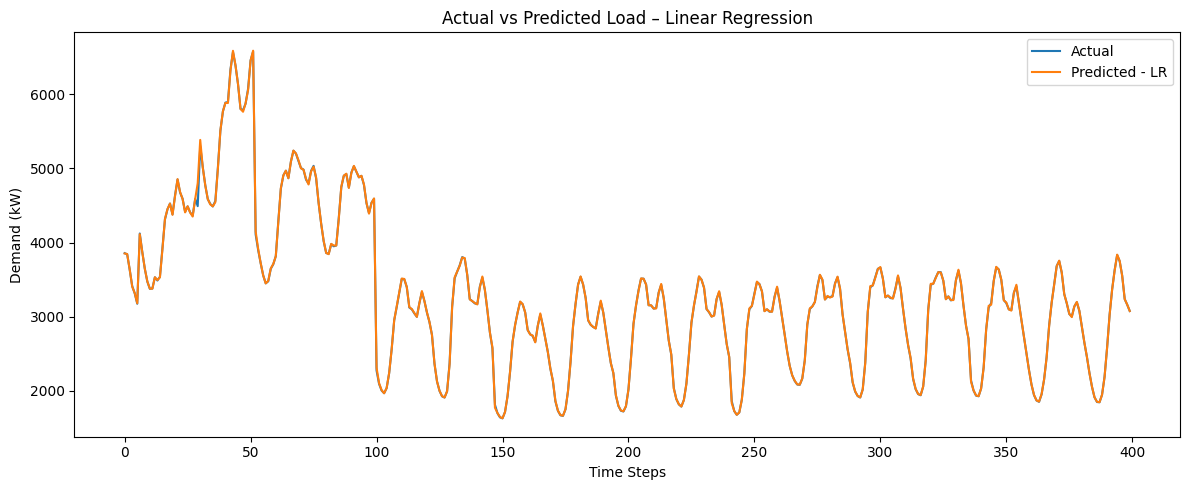

In [11]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:400], label="Actual")
plt.plot(pred_lr[:400], label="Predicted - LR")
plt.title("Actual vs Predicted Load – Linear Regression")
plt.xlabel("Time Steps")
plt.ylabel("Demand (kW)")
plt.legend()
plt.tight_layout()
plt.show()


### 9.2 Random Forest


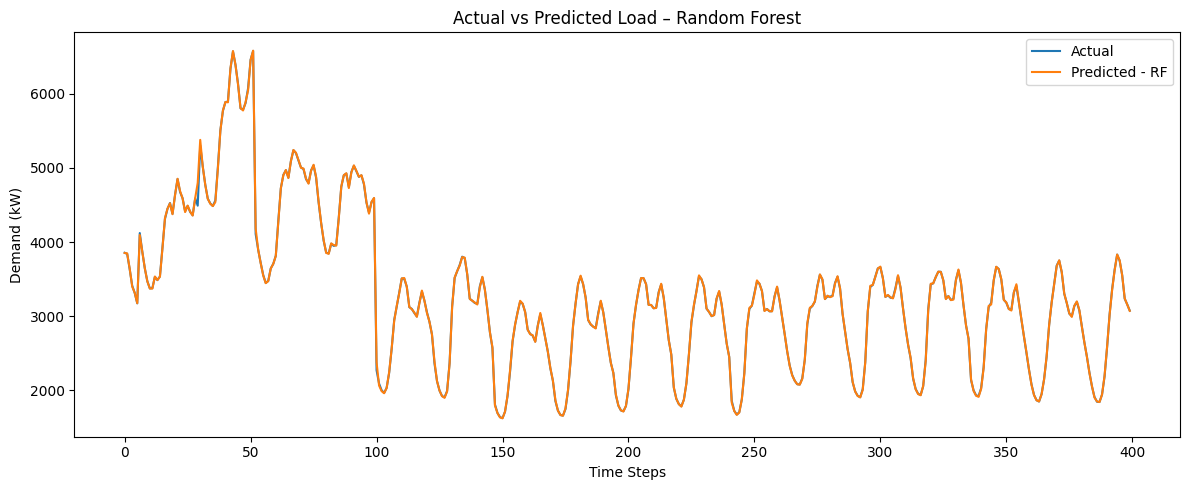

In [12]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:400], label="Actual")
plt.plot(pred_rf[:400], label="Predicted - RF")
plt.title("Actual vs Predicted Load – Random Forest")
plt.xlabel("Time Steps")
plt.ylabel("Demand (kW)")
plt.legend()
plt.tight_layout()
plt.show()


## 10. Feature Importance – Random Forest


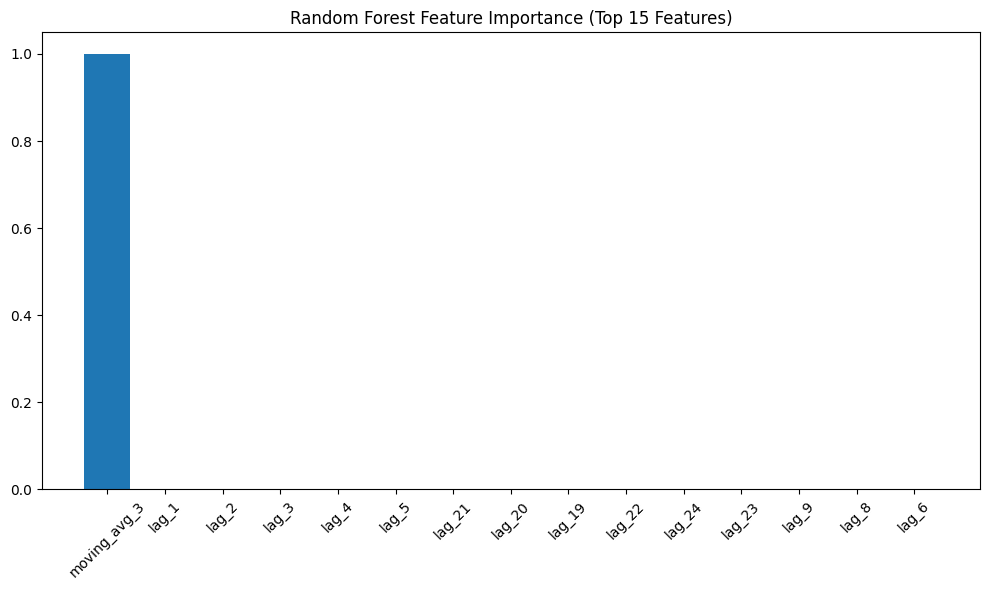

In [15]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 15

plt.figure(figsize=(10,6))
plt.bar(range(top_n), importances[indices][:top_n])
plt.xticks(range(top_n), [X.columns[i] for i in indices][:top_n], rotation=45)
plt.title("Random Forest Feature Importance (Top 15 Features)")
plt.tight_layout()
plt.show()


## 12. Electricity Demand Trend – Last 30 Days


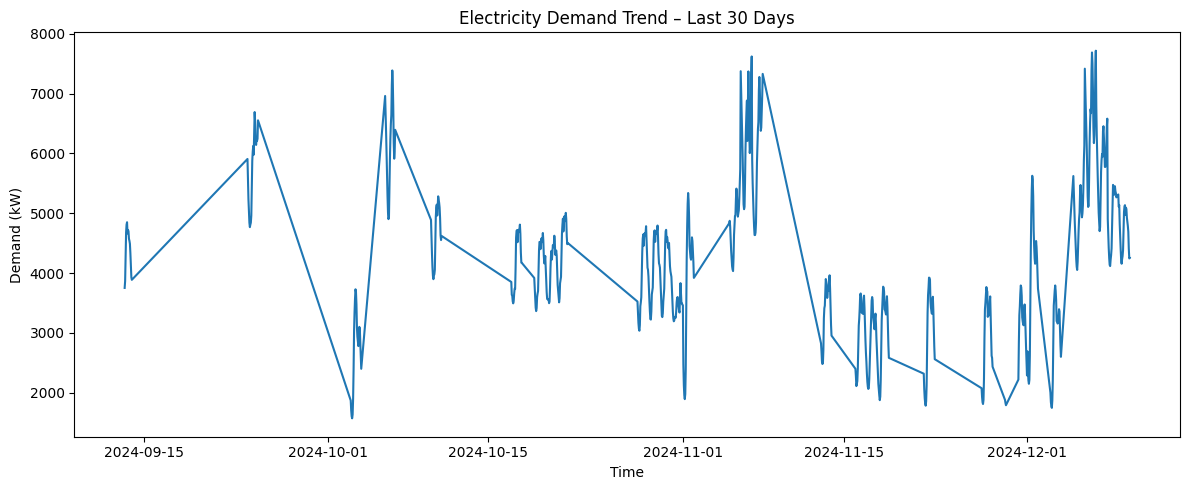

In [17]:
target_col = "Power demand"
plt.figure(figsize=(12,5))
plt.plot(df_hourly[target_col].tail(24*30))
plt.title("Electricity Demand Trend – Last 30 Days")
plt.xlabel("Time")
plt.ylabel("Demand (kW)")
plt.tight_layout()
plt.show()


## 12. Summary

In this notebook we:

- Loaded and preprocessed Delhi electricity demand and weather data  
- Engineered lag, moving average, and time features  
- Used an 80–20 chronological split to train and test models  
- Implemented Baseline, Linear Regression, Random Forest, and XGBoost (optional)  
- Evaluated using **MAE** and **RMSE**  
- Visualized predictions and feature influence

This notebook can be submitted along with the research paper as implementation proof.


In [18]:
import joblib

# Save trained models
joblib.dump(lr, "lr_model.pkl")
joblib.dump(rf, "rf_model.pkl")

# If you trained XGBoost:
try:
    joblib.dump(xgb, "xgb_model.pkl")
    print("XGB saved")
except:
    print("XGB not available")

# Save metadata for UI
feature_cols = X_train.columns.tolist()
example_row = X_test.iloc[-1]

joblib.dump(feature_cols, "feature_cols.pkl")
joblib.dump(example_row, "example_row.pkl")

print("All models & metadata saved successfully!")


XGB saved
All models & metadata saved successfully!


In [20]:


# 1) Make sure feature_cols matches what you used for training
feature_cols = X_train.columns.tolist()

# 2) Create example row (last test row) to use as UI default
example_row = X_test.iloc[-1]

# 3) Build metrics dictionary exactly matching the model names in app.py
model_metrics = {
    "Linear Regression": {
        "MAE": mae_lr,
        "RMSE": rmse_lr
    },
    "Random Forest": {
        "MAE": mae_rf,
        "RMSE": rmse_rf
    },
    "XGBoost": {
        "MAE": mae_xgb,
        "RMSE": rmse_xgb
    }
}

# 4) Save models – you already did this, but safe to re-run
joblib.dump(lr, "lr_model.pkl")
joblib.dump(rf, "rf_model.pkl")
joblib.dump(xgb, "xgb_model.pkl")

# 5) Save metadata & metrics
joblib.dump(feature_cols, "feature_cols.pkl")
joblib.dump(example_row, "example_row.pkl")
joblib.dump(model_metrics, "model_metrics.pkl")

print("✅ All models, metadata, and metrics saved successfully!")


✅ All models, metadata, and metrics saved successfully!


In [21]:
import requests

api_key = "b3f37729fdd87f01a33138e55e19494d"   # replace with your real key
city = "Delhi"

url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric"

response = requests.get(url)
print(response.status_code)
print(response.json())


200
{'coord': {'lon': 77.2167, 'lat': 28.6667}, 'weather': [{'id': 721, 'main': 'Haze', 'description': 'haze', 'icon': '50n'}], 'base': 'stations', 'main': {'temp': 16.05, 'feels_like': 15.15, 'temp_min': 16.05, 'temp_max': 16.05, 'pressure': 1018, 'humidity': 55, 'sea_level': 1018, 'grnd_level': 992}, 'visibility': 3000, 'wind': {'speed': 2.06, 'deg': 250}, 'clouds': {'all': 39}, 'dt': 1765298023, 'sys': {'type': 1, 'id': 9165, 'country': 'IN', 'sunrise': 1765243952, 'sunset': 1765281275}, 'timezone': 19800, 'id': 1273294, 'name': 'Delhi', 'cod': 200}
